## Modules

In [1]:
# import basic modules
import pandas as pd
import warnings
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# import all modules related to visualization
from matplotlib import style
from matplotlib.pyplot import plot
from matplotlib import pyplot
from matplotlib.collections import PolyCollection
from pandas.plotting import autocorrelation_plot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
# import all modules related to statistical computing
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import q_stat, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import scipy.stats as stats

In [4]:
# filter all warnings
warnings.filterwarnings("ignore")

## Get Training Data

In [5]:
# import the training data
training = pd.read_csv(os.getcwd() + "/Data/training.csv")
print(training)

           DATE     GDPC1
0    1949-04-01 -0.341097
1    1949-07-01  1.032415
2    1949-10-01 -0.839275
3    1950-01-01  3.930121
4    1950-04-01  3.049835
..          ...       ...
274  2017-10-01  0.955677
275  2018-01-01  0.931679
276  2018-04-01  0.668628
277  2018-07-01  0.525196
278  2018-10-01  0.328321

[279 rows x 2 columns]


In [6]:
# set the date as index
training["DATE"] = pd.to_datetime(training["DATE"])
training = training.set_index("DATE")

## Model Evaluation

In [7]:
# further split the training data into training and validation sets
# 70% training and 30% validation
training_size = int(len(training) * 0.8)
train, val = training[0:training_size], training[training_size:]

In [8]:
# compute the mape error statistic
def mape_score(actual, y_hat):
    mape = np.mean(np.abs((actual - y_hat) / actual)) * 100
    return mape

In [9]:
# pseudo-out-of-sample forecast evaluation for arima models:
# 1. fit model parameters on the training sample
# 2. produce one-step-ahead forecasts from the end of that sample
# 3. expand the sample to include the next observation, and repeat
# 4. compare forecasts against validation dataset to compute rmse
def evaluate_model(training, validation, order):
    history = [x for x in training.values]
    predictions = list()
    aicc_values = list()
    # iterate over each value in the validation set
    for t in range(len(validation.values)):
        # fit model on training sample
        model = ARIMA(history, order = order)
        model_fit = model.fit()
        # compute one-step-ahead forecast
        y_hat = model_fit.forecast()[0]
        predictions.append(y_hat)
        aicc_values.append(model_fit.aicc)
        # expand the training sample to include next observation 
        history.append(validation.values[t])
    # compute rmse & mape
    rmse = np.sqrt(mean_squared_error(validation.values, predictions)) * 100
    mape = mape_score(validation.values, predictions)
    model_data = validation.copy()
    model_data["prediction"] = predictions
    aicc_values = np.asarray(aicc_values)
    return rmse, mape, model_data, aicc_values.mean()

In [10]:
# function for grid-search of the best combination of the arima parameters (p,d,q)
def grid_search(training, validation, p_values, d, q_values):
    best_score, best_cfg = float("inf"), None
    rmse_values = list()
    mape_values = list()
    aicc_values = list()
    for p in p_values:
        for q in q_values:
            order = (p,d,q)
            try:
                rmse, mape, model_data, aicc = evaluate_model(training, validation, order)
                if (rmse + mape / 2) < best_score:
                    best_score, best_cfg, model_data = (rmse + mape / 2), order, model_data
                print("ARIMA%s -> score = %.3f" % (order, (rmse + mape / 2)))
                rmse_values.append(rmse)
                mape_values.append(mape)
                aicc_values.append(aicc)
            except:
                continue
    # standardize rmse values
    rmse_values = np.asarray(rmse_values)
    rmse_values = (rmse_values - rmse_values.mean()) / rmse_values.std()
    # standardize mape values
    mape_values = np.asarray(mape_values)
    mape_values = (mape_values - mape_values.mean()) / mape_values.std()
    # standardize aicc values
    aicc_values = np.asarray(aicc_values)
    aicc_values = (aicc_values - aicc_values.mean()) / aicc_values.std()
    # print best model and return best configuration and best scores 
    print("Best ARIMA%s with score of %.3f" % (best_cfg, best_score))
    return best_cfg, model_data, rmse_values, mape_values, aicc_values

In [41]:
# function for visualization of model training and the corresponding rmse
def plot_model(model_data, rmse, mape, aicc):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    
    # plot model training
    ax1.plot(model_data.iloc[:,0], color = "darkblue", label = "Validation Data")
    ax1.plot(model_data.iloc[:,1], color = "red", label = "Fitted Values", linestyle = "-")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Real GDP Growth")
    ax1.set_title("Fitted Values for best ARIMA Combination", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax1.legend(frameon = False)
    
    # plot rmse values
    ax2.plot(rmse, color = "green", label = "RMSE")
    ax2.plot(mape, color = "red", label = "MAPE")
    ax2.plot(aicc, color = "darkblue", label = "AICc")
    ax2.plot((rmse + mape + aicc) / 3, color = "black", label = "Average", linestyle = "--")
    ax2.set_xlabel("Grid-Search Iteration")
    ax2.set_ylabel("Score")
    ax2.set_title("Corresponding RMSE, MAPE & AICc Values", loc = "left")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax2.legend(frameon = False)

In [43]:
# select range of (p,d,q) parameters for grid-search
p, d, q = range(0,11), 1, range(0,1)

In [44]:
# run the grid-search
best_cfg, model_data, rmse_values, mape_values, aicc_values = grid_search(train, val, p, d, q)

ARIMA(0, 1, 0) -> score = 152.482
ARIMA(1, 1, 0) -> score = 139.472
ARIMA(2, 1, 0) -> score = 137.269
ARIMA(3, 1, 0) -> score = 136.535
ARIMA(4, 1, 0) -> score = 134.238
ARIMA(5, 1, 0) -> score = 131.761
ARIMA(6, 1, 0) -> score = 130.884
ARIMA(7, 1, 0) -> score = 129.795
ARIMA(8, 1, 0) -> score = 128.016
ARIMA(9, 1, 0) -> score = 127.242
ARIMA(10, 1, 0) -> score = 127.491
Best ARIMA(9, 1, 0) with score of 127.242


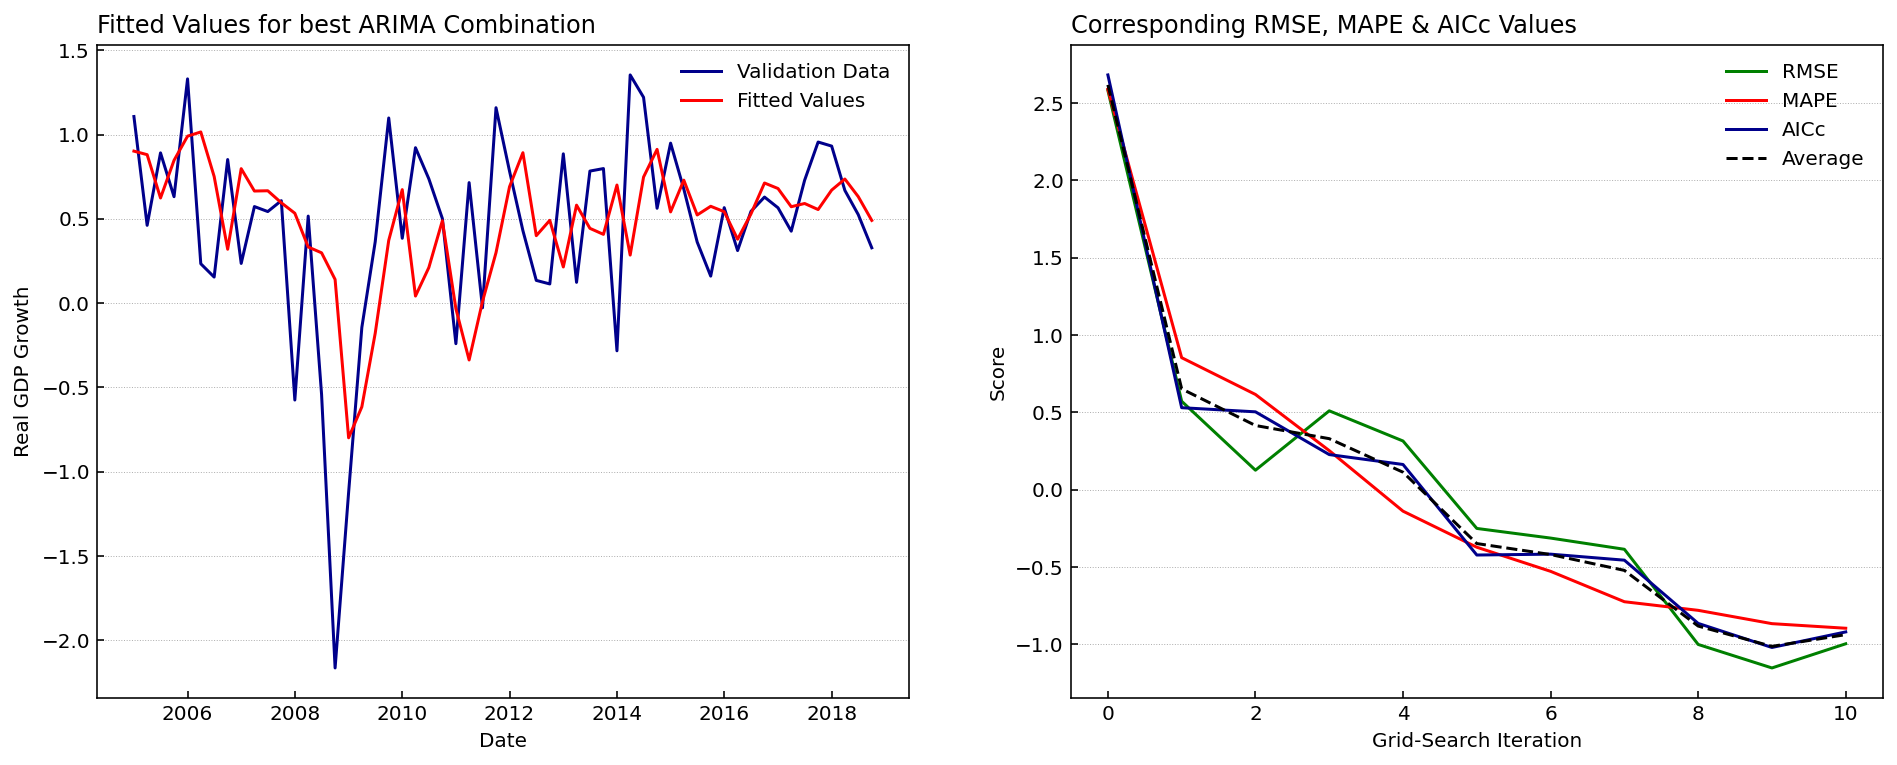

In [45]:
# plot the model training
plot_model(model_data, rmse_values, mape_values, aicc_values)

## Residual Diagnostics

In [46]:
# function for visualization of the residuals for the chosen arima model
# good forecasting methods will yield innovation residuals with the following properties:
# 1. The innovation residuals are uncorrelated (otherwise there is information left)
# 2. The innovation residuals have zero mean (otherwise the forecasts are biased)
# 3. The innovation residuals have constant variance (useful, but not necessary)
# 4. The innovation residuals are normally distributed (useful, but not necessary)
def plot_residuals(data, order):
    # get residuals for the chosen combination of (p,d,q) parameters
    model = ARIMA(data, order = order)
    model_fit = model.fit()
    residuals = pd.DataFrame(model_fit.resid)
    
    # distribution plot using simple returns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    residuals.plot(kind = "density", ax = ax1, color = "darkblue", legend = False)
    ax1.set_title("Residuals Density with Normal Distribution", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # normal distribution
    mean, std = stats.norm.fit(residuals)
    x = np.linspace(-8, 8, 300)
    p = stats.norm.pdf(x, mean, std)
    ax1.plot(x, p, "green")
    ax1.legend(["Residuals", "Normal"], frameon = False)
    ax1.axvline(x = 0, color = "red", linestyle = "--")
    
    # compute the autocorrelation coefficients of the residuals and plot them
    plot_acf(residuals, ax = ax2, title = "", zero = False, color = "darkblue", 
             vlines_kwargs = {"colors": "darkblue"}, lags = int(len(data)) - 1, use_vlines = False)
    ax2.axhline(y = 0, color = "red", linestyle = "--")
    ax2.set_title("Autocorrelation Function of Residuals", loc = "left")
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Autocorrelation")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    for item in ax2.collections:
        if type(item) == PolyCollection:
            item.set_facecolor("blue")
            
    # return the residual values
    return residuals

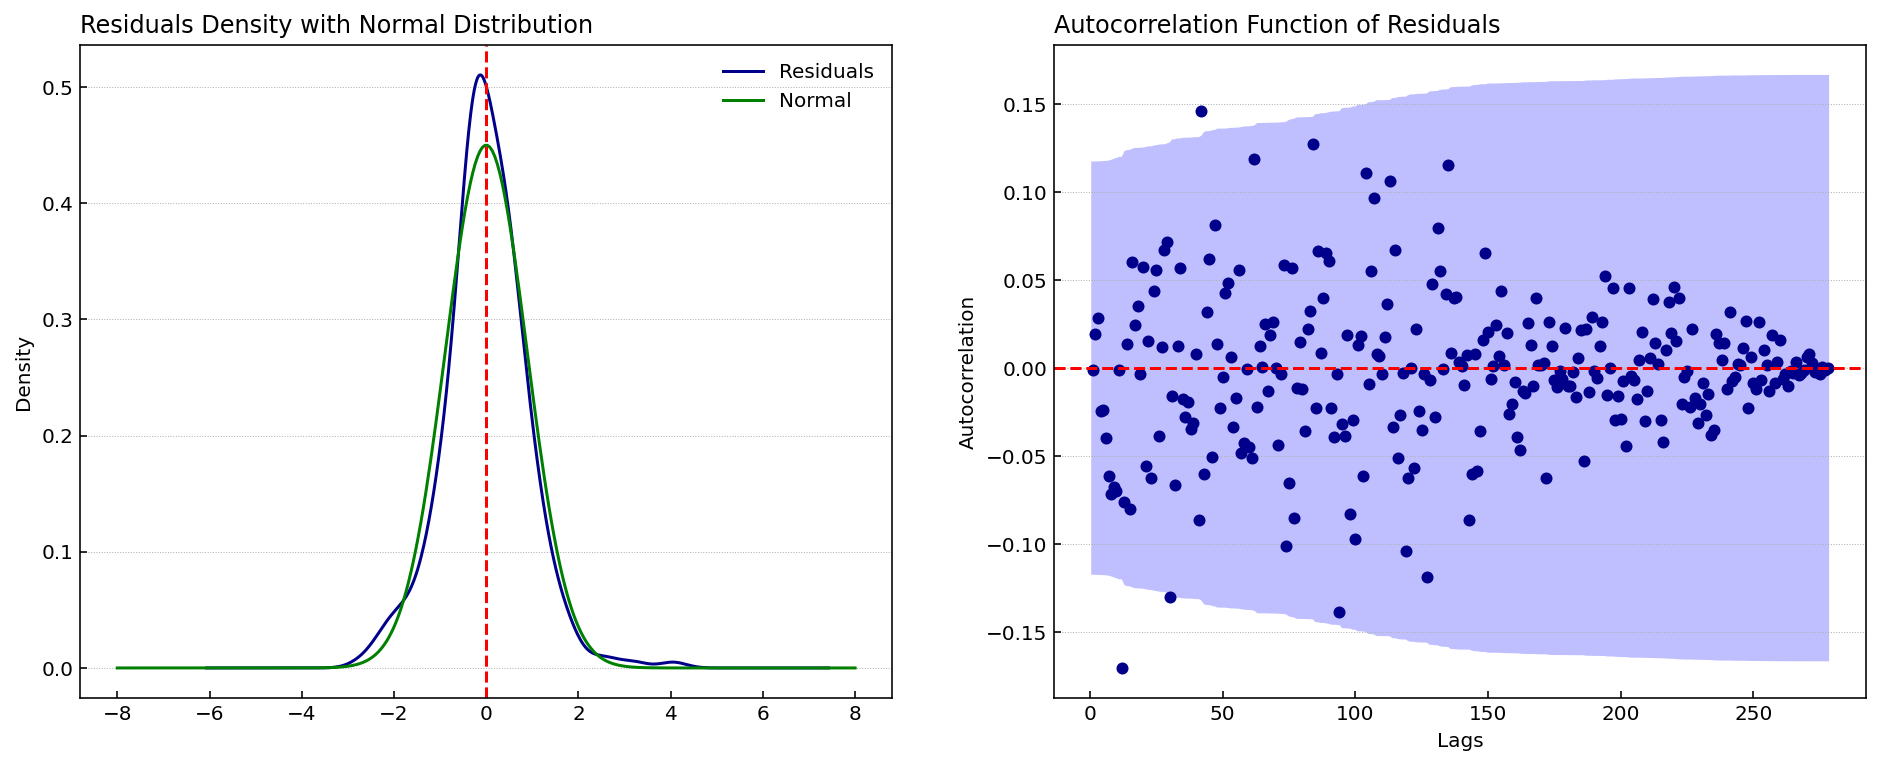

In [47]:
residuals = plot_residuals(training, best_cfg)

In [48]:
# Ljung-Box-Q test
# null hypothesis : data is independently distributed (no autocorrelation)
# alternate hypothesis : data is not independently distributed
# reject null hypothesis if p-value <= 0.05
def lbq_test(data):
    lbq_test = acorr_ljungbox(data)
    test_statistic, p_value = lbq_test[0].mean(), lbq_test[1].mean()
    print("Ljung-Box-Q test results")
    print("-> average test statistic: " + str(round(test_statistic, 2)))
    print("-> aberage p-value: "  + str(round(p_value, 2)))

In [49]:
lbq_test(residuals)

Ljung-Box-Q test results
-> average test statistic: 20.36
-> aberage p-value: 0.54


In [50]:
# Jarque-Bera test
# null hypothesis : data is normally distributed
# alternate hypothesis : data is not normally distributed
# reject null hypothesis if p-value <= 0.05
def jb_test(data):
    jb_test = jarque_bera(data)
    test_statistic, p_value, skew, kurtosis = jb_test[0].mean(), jb_test[1].mean(), jb_test[2].mean(), jb_test[3].mean()
    print("Jarque-Bera test results")
    print("-> test statistic: " + str(round(test_statistic, 2)))
    print("-> p-value: "  + str(round(p_value, 2)))
    print("-> estimated skew: "  + str(round(skew, 2)))
    print("-> estimated kurtosis: "  + str(round(kurtosis, 2)))

In [51]:
jb_test(residuals)

Jarque-Bera test results
-> test statistic: 54.05
-> p-value: 0.0
-> estimated skew: 0.29
-> estimated kurtosis: 5.07


## Out-of-Sample Forecast with Test Data

In [52]:
# import the test data and set date as index
testing = pd.read_csv(os.getcwd() + "/Data/testing.csv")
testing["DATE"] = pd.to_datetime(testing["DATE"])
testing = testing.set_index("DATE")

In [53]:
# function for forecasting on test data with chosen arima model
def forecast(training, testing, order):
    model = ARIMA(training, order = order)
    model_fit = model.fit()
    y_hat = model_fit.forecast(steps = len(testing))
    rmse = np.sqrt(mean_squared_error(testing, y_hat))
    print("RMSE = " + str(rmse))
    return y_hat

In [54]:
y_hat = forecast(training, testing, best_cfg)

RMSE = 0.15076890112007282


In [55]:
# function for visualization of the forecast
def plot_forecast(training, testing, y_hat):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    
    ax1.plot(training["2010-01-01":"2018-10-01"], color = "darkblue", label = "Training Data")
    ax1.plot(testing, color = "green", label = "Test Data")
    ax1.plot(y_hat, color = "red", label = "Forecasted Values")
    ax1.set_xlabel("Date")
    ax1.set_title("Forecast", loc = "left")
    ax1.legend(frameon = False)
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    ax2.plot(testing, color = "green")
    ax2.plot(y_hat, color = "red")
    ax2.set_xlabel("Date")
    ax2.set_title("Forecast (zoomed-in)", loc = "left")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

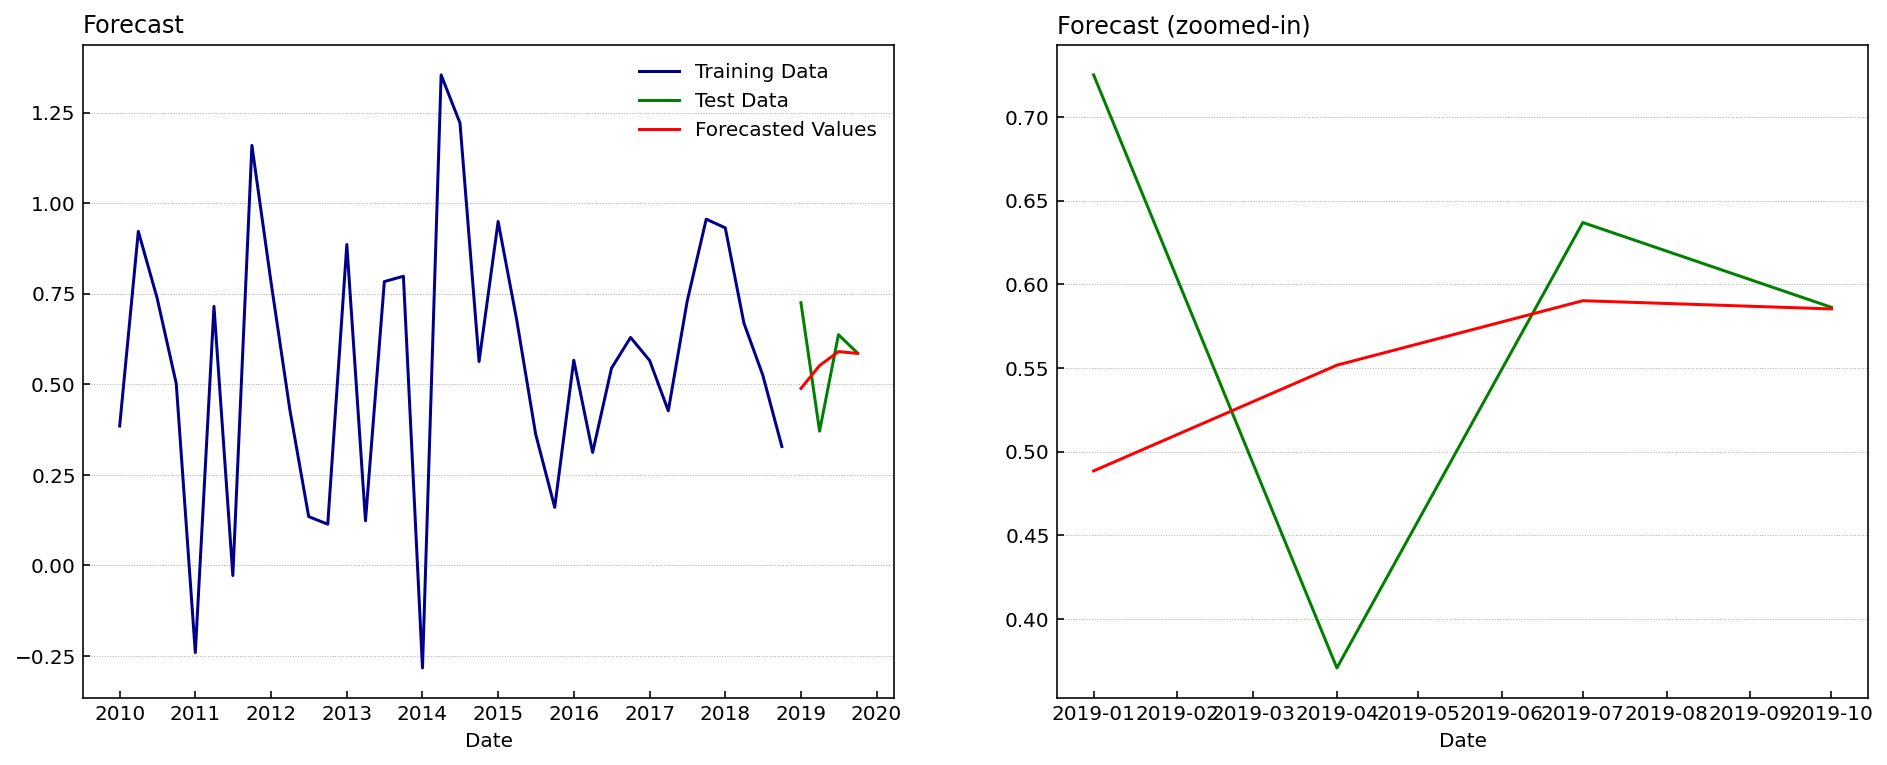

In [56]:
plot_forecast(training, testing, y_hat)